# Linear stokes sinker

The stokes sinker is a benchmark to test sinking velocities determined by the stokes solver.

Two materials are used, one for the background and one for the sinking ball.

Stokes velocity is calculated and compared with the velocity from the UW model to benchmark the stokes solver


In [1]:
from petsc4py import PETSc
import underworld3 as uw
from underworld3.systems import Stokes
import numpy as np
import sympy
from mpi4py import MPI
import os

import zarr

In [2]:
# import pyvista as pv
# import vtk

In [3]:
#### visualisation within script
render = True

#### save output
save_output = False

In [4]:
### number of steps for the model
nstep = 1

In [5]:
### stokes tolerance
tol = 1e-5

In [ ]:
outputPath = f"./stokes_output/sinker_eta1e6_rho10/"

outfile = outputPath + "/stokes"

if uw.mpi.rank==0:      
    ### create folder if not run before
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [6]:
# Set size and position of dense sphere.
sphereRadius = 0.1
sphereCentre = (0.0, 0.7)

In [7]:
# define some names for our index
materialLightIndex = 0
materialHeavyIndex = 1

In [8]:
# Set constants for the viscosity of each material
viscBG     =  1.0
viscSphere = 1000.0

In [9]:
# set density of the different materials
densityBG     =  0.0
densitySphere = 10.0

In [10]:
# location of tracer at bottom of sinker
x_pos = sphereCentre[0]
y_pos = sphereCentre[1] - sphereRadius

In [11]:
nsteps = 2

In [12]:
# mesh = uw.meshing.UnstructuredSimplexBox(
#     minCoords=(-1.0, 0.0), maxCoords=(1.0, 1.0), cellSize=1.0 / res, regular=True
# )

x_min = -1.
x_max = 1.
z_min = 0
z_max = 1
res = 80

# mesh = uw.meshing.StructuredQuadBox(minCoords=(x_min, z_min), maxCoords=(x_max, z_max),  elementRes=(res,res))
mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(x_min, z_min), maxCoords=(x_max, z_max), cellSize=1.0 / res, regular=False
)

####  Create Stokes object and the required mesh variables (velocity and pressure)

In [13]:
v = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)
bfz = uw.discretisation.MeshVariable("BF", mesh, 1, degree=2) # for the body force
visc = uw.discretisation.MeshVariable("VISC", mesh, 1, degree=2)

In [14]:
stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
stokes.constitutive_model = uw.systems.constitutive_models.ViscousFlowModel(mesh.dim)

In [15]:
### free slip BC

stokes.add_dirichlet_bc( (0.,0.), 'Left',   (0) ) # left/right: function, boundaries, components
stokes.add_dirichlet_bc( (0.,0.), 'Right',  (0) )

stokes.add_dirichlet_bc( (0.,0.), 'Top',    (1) )
stokes.add_dirichlet_bc( (0.,0.), 'Bottom', (1) )# top/bottom: function, boundaries, components 

####  Add a particle swarm which is used to track material properties 

In [16]:
swarm = uw.swarm.Swarm(mesh=mesh)
material = uw.swarm.IndexSwarmVariable("M", swarm, indices=2)
swarm.populate(fill_param=4)

Create an array which contains:
- the x and y coordinate of the sphere (0,1), 
- the radius (2) and 
- the material index (3)

In [17]:
sphere = np.array(
    [[sphereCentre[0], sphereCentre[1], sphereRadius, 1]]
    )

Update the material variable to include the background and sphere

In [18]:
with swarm.access(material):
    material.data[...] = materialLightIndex

    for i in range(sphere.shape[0]):
        cx, cy, r, m = sphere[i, :]
        inside = (swarm.data[:, 0] - cx) ** 2 + (swarm.data[:, 1] - cy) ** 2 < r**2
        material.data[inside] = m

In [19]:
### add tracer for sinker velocity
tracer_coords = np.zeros(shape=(1, 2))
tracer_coords[:, 0], tracer_coords[:, 1] = x_pos, y_pos

In [20]:
tracer = uw.swarm.Swarm(mesh=mesh)

In [21]:
tracer.add_particles_with_coordinates(tracer_coords)

In [22]:

density_fn = material.createMask([densityBG, densitySphere])

In [23]:
# density_fn

In [24]:
### assign material viscosity

viscosity_fn = material.createMask([viscBG, viscSphere])


In [25]:
# viscosity_fn

In [26]:
# pv.global_theme.background = "white"
# pv.global_theme.window_size = [750, 750]
# pv.global_theme.antialiasing = True
# pv.global_theme.jupyter_backend = "panel"
# pv.global_theme.smooth_shading = True
# pv.global_theme.camera["viewup"] = [0.0, 1.0, 0.0]
# pv.global_theme.camera["position"] = [0.0, 0.0, 5.0]

In [43]:
stokes.constitutive_model.Parameters.viscosity = viscosity_fn
stokes.bodyforce = sympy.Matrix([0, -1 * density_fn])
stokes.saddle_preconditioner = 1.0 / stokes.constitutive_model.Parameters.viscosity

# projection object to calculate the body force on the mesh 
bfz_calc = uw.systems.Projection(mesh, bfz)
bfz_calc.uw_function = -1*density_fn
bfz_calc.smoothing = 1.0e-5
bfz_calc.petsc_options.delValue("ksp_monitor")

# projection object to calculate the gradient along Z
visc_calc = uw.systems.Projection(mesh, visc)
visc_calc.uw_function = viscosity_fn
visc_calc.smoothing = 1.0e-5
visc_calc.petsc_options.delValue("ksp_monitor")

In [45]:
with mesh.access():
    print(bfz.data.min())
    print(visc.data.max())

-10.000428782696462
1000.0429079848822


In [38]:
stokes.tolerance = tol

In [41]:
step = 0
time = 0.0

In [42]:
tSinker = np.zeros(nsteps)*np.nan
ySinker = np.zeros(nsteps)*np.nan

In [43]:
if uw.mpi.size == 1:
    stokes.petsc_options['pc_type'] = 'lu'

In [44]:
stokes.petsc_options.view()

#PETSc Option Table entries:
-coordinterp_petscdualspace_lagrange_continuity false
-coordinterp_petscdualspace_lagrange_node_endpoints false
-coordinterp_petscspace_degree 4
-dm_plex_gmsh_mark_vertices true
-dm_plex_gmsh_multiple_tags true
-dm_plex_gmsh_use_regions
-dm_plex_hash_location
-meshproj_1_petscspace_degree 1
-meshproj_2_petscspace_degree 1
-Stokes_1__pprivate_petscdualspace_lagrange_continuity true
-Stokes_1__pprivate_petscdualspace_lagrange_node_endpoints false
-Stokes_1__pprivate_petscspace_degree 1
-Stokes_1__uprivate_petscspace_degree 2
-Stokes_1_fieldsplit_pressure_ksp_rtol 1.0000000000000002e-06
-Stokes_1_fieldsplit_pressure_ksp_type fgmres
-Stokes_1_fieldsplit_pressure_pc_gasm_type basic
-Stokes_1_fieldsplit_pressure_pc_type gasm
-Stokes_1_fieldsplit_velocity_ksp_rtol 1.0000000000000002e-06
-Stokes_1_fieldsplit_velocity_ksp_type cg
-Stokes_1_fieldsplit_velocity_mg_levels_ksp_converged_maxits
-Stokes_1_fieldsplit_velocity_mg_levels_ksp_max_it 3
-Stokes_1_fieldsplit_vel

In [45]:
# # calculate the body force on a coordinate grid - since FNO accepts rectangular grids
# x_grid = np.linspace(x_min, 0.9999999*x_max, res)
# z_grid = np.linspace(z_min, 0.9999999*z_max, res)

# xx, zz = np.meshgrid(x_grid, z_grid)

# pos_eval = np.zeros((xx.flatten().shape[0], 2))
# pos_eval[:, 0] = xx.flatten()
# pos_eval[:, 1] = zz.flatten()

#### Stokes solver loop

In [46]:
while step < nsteps:
    ### Get the position of the sinking ball
    with tracer.access():
        ymin = tracer.data[:,1].min()

    if ymin <= 1e-5: # break if tracer is close to bottom
        break

    ySinker[step] = ymin
    tSinker[step] = time
    
    ### print some stuff
    if uw.mpi.rank == 0:
        print(f"Step: {str(step).rjust(3)}, time: {time:6.2f}, tracer:  {ymin:6.2f}")

    ### solve stokes
    stokes.solve(zero_init_guess=True)
    
    ### estimate dt
    dt = stokes.estimate_dt()

    ### advect the swarm
    swarm.advection(stokes.u.sym, dt, corrector=False)


    ### advect tracer
    tracer.advection(stokes.u.sym, dt, corrector=False)

    bfz_calc.solve()
    visc_calc.solve()

    mesh.write_timestep_xdmf(filename = outfile, meshVars=[v, p, bfz, visc], index=step)
    # #  calculate the body force, ux, uz, pressure
    # bf_z = uw.function.evaluate(-1*density_fn, pos_eval)
    # ux_proj = uw.function.evaluate(v.sym[0], pos_eval)
    # uz_proj = uw.function.evaluate(v.sym[1], pos_eval)
    # p_proj = uw.function.evaluate(p.sym[0], pos_eval)
    # visc_proj = uw.function.evaluate(viscosity_fn, pos_eval)

    # bf_z_rev = bf_z.reshape(xx.shape) # revert to rectangular mesh shape
    # ux_rev = ux_proj.reshape(xx.shape)
    # uz_rev = uz_proj.reshape(xx.shape)
    # p_rev = p_proj.reshape(xx.shape)
    # visc_rev = visc_proj.reshape(xx.shape)

    # # pack the predictables one array - L, R, C
    # vxvzp = np.zeros([3, xx.shape[0], xx.shape[1]])
    # vxvzp[0, :, :] = ux_rev
    # vxvzp[1, :, :] = uz_rev
    # vxvzp[2, :, :] = p_rev

    # # pack the inputs one array - L, R, C
    # bfv = np.zeros([2, xx.shape[0], xx.shape[1]]) # body force and viscosity
    # bfv[0, :, :] = bf_z_rev
    # bfv[1, :, :] = visc_rev

    # # save the inputs and outputs
    # zarr.save(outputPath + "/vxvzp_{}.zarr".format(step), vxvzp)
    # zarr.save(outputPath + "/bfv_{}.zarr".format(step), bfv)

    step += 1
    time += dt

Step:   0, time:   0.00, tracer:    0.60


  0 SNES Function norm 0.0115633 
  1 SNES Function norm 2.58336e-09 
Nonlinear Stokes_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


In [ ]:
# mesh.petsc_save_checkpoint(meshVars=[v, p,], index=step, outputPath=outputPath)
# swarm.petsc_save_checkpoint(swarmName='swarm', index=step, outputPath=outputPath)
# tracer.petsc_save_checkpoint(swarmName='tracer', index=step, outputPath=outputPath)

In [ ]:
# stokesSink_vel = (((2*sphereRadius)**2)*(densitySphere - densityBG)*1)/18*viscBG
# if uw.mpi.rank==0:
#     print(f'stokes sinking velocity: {stokesSink_vel}')

stokes sinking velocity: 0.022222222222222227


#### Compare velocity from the model with numerical solution to benchmark the Stokes solver

In [ ]:
# if uw.mpi.rank==0:
    
#     ### remove nan values, if any
#     ySinker = ySinker[~np.isnan(y)]
#     tSinker = tSinker[~np.isnan(tSinker)]
    
#     t_benchmark = np.arange(0, tSinker.max(), 0.1)
#     v_benchmark = 0.6 - (t_benchmark*stokesSink_vel)
    
    
#     print('Initial position: t = {0:.3f}, y = {1:.3f}'.format(tSinker[0], ySinker[0]))
#     print('Final position:   t = {0:.3f}, y = {1:.3f}'.format(tSinker[-1], ySinker[-1]))
    
    
#     velocity = (ySinker[0] - ySinker[-1]) / (tSinker[-1] - tSinker[0])
#     print(f'Velocity:         v = {velocity}')

Initial position: t = 0.000, y = 0.600
Final position:   t = 0.000, y = 0.600
Velocity:         v = nan


/var/folders/sj/jbtsvyqn1d556dgk71dlv3_x665gb7/T/ipykernel_84738/3757957407.py:15: RuntimeWarning: invalid value encountered in scalar divide
  velocity = (ySinker[0] - ySinker[-1]) / (tSinker[-1] - tSinker[0])


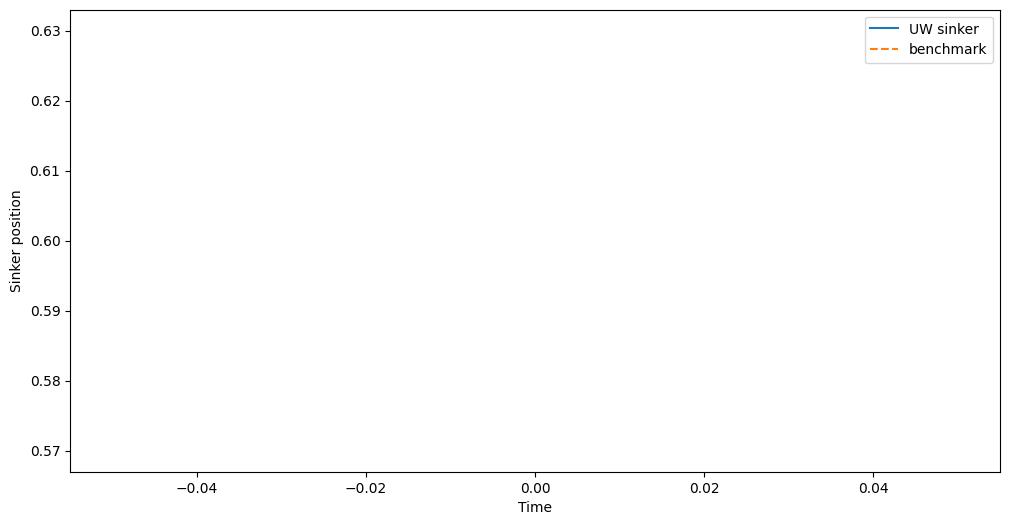

In [ ]:
# if uw.mpi.size==1:    
#     import matplotlib.pyplot as pyplot

#     fig = pyplot.figure()
#     fig.set_size_inches(12, 6)
#     ax = fig.add_subplot(1,1,1)
#     ax.plot(tSinker, ySinker, label='UW sinker') 
    
#     ax.plot(t_benchmark, v_benchmark, ls='--', label='benchmark') 
    
#     ax.legend()
    
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Sinker position')

In [ ]:
# if uw.mpi.size == 1:

#     import numpy as np
#     import pyvista as pv
#     import vtk

#     pv.global_theme.background = "white"
#     pv.global_theme.window_size = [750, 250]
#     pv.global_theme.antialiasing = True
#     pv.global_theme.jupyter_backend = "panel"
#     pv.global_theme.smooth_shading = True

#     # pv.start_xvfb()
#     mesh.vtk(outputPath +"tmpMsh.vtk")
#     pvmesh = pv.read(outputPath +"tmpMsh.vtk")

#     # pvmesh.point_data["S"]  = uw.function.evaluate(s_soln.fn, meshbox.data)

#     with mesh.access():
#         vsol = v.data.copy()

#     with swarm.access():
#         points = np.zeros((swarm.data.shape[0], 3))
#         points[:, 0] = swarm.data[:, 0]
#         points[:, 1] = swarm.data[:, 1]
#         points[:, 2] = 0.0

#     point_cloud = pv.PolyData(points)

#     with swarm.access():
#         point_cloud.point_data["M"] = material.data.copy()

#     arrow_loc = np.zeros((v.coords.shape[0], 3))
#     arrow_loc[:, 0:2] = v.coords[...]

#     arrow_length = np.zeros((v.coords.shape[0], 3))
#     arrow_length[:, 0:2] = vsol[...]

#     pl = pv.Plotter()

#     pl.add_mesh(pvmesh, "Black", "wireframe")

#     pvmesh.point_data["rho"] = uw.function.evaluate(density_fn, mesh.data)

#     # pl.add_mesh(pvmesh, cmap="coolwarm", edge_color="Black", show_edges=True, scalars="rho",
#     #                 use_transparency=False, opacity=0.95)

#     # pl.add_mesh(pvmesh, cmap="coolwarm", edge_color="Black", show_edges=True, scalars="S",
#     #               use_transparency=False, opacity=0.5)

#     pl.add_mesh(
#         point_cloud,
#         cmap="coolwarm",
#         edge_color="Black",
#         show_edges=False,
#         scalars="M",
#         use_transparency=False,
#         opacity=0.95,
#     )

#     pl.add_arrows(arrow_loc, arrow_length, mag=5.0, opacity=0.5)
#     # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

#     # pl.add_points(pdata)

#     pl.show(cpos="xy")

/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2489: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2457: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/sj/jbtsvyqn1d556dgk71dlv3_x665gb7/T/ipykernel_84738/2678205352.py:10: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'b76294d5-0226-44b5-a4c0-b0b38b5109d3': {'defs': …

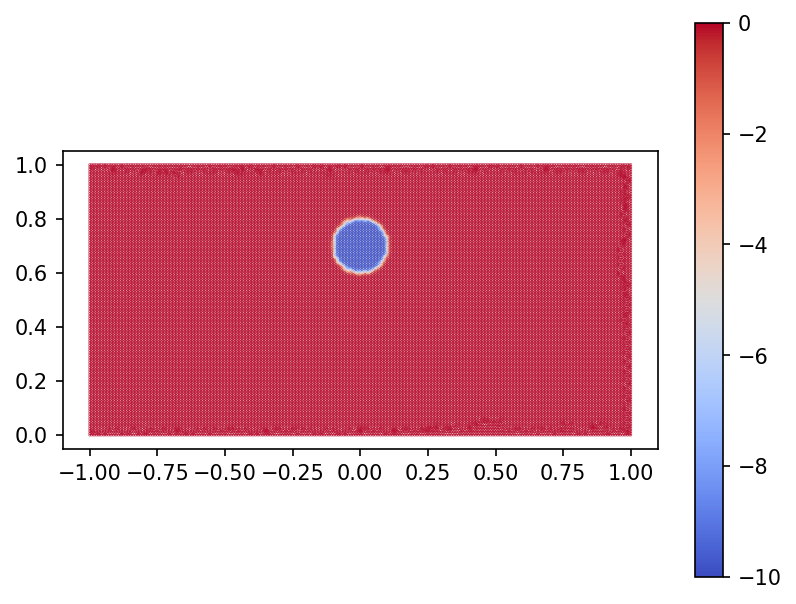

In [51]:
# import matplotlib.pyplot as plt

# with mesh.access():
#     # fig, ax = plt.subplots(dpi = 150)
#     # out = ax.scatter(xx.flatten(), zz.flatten(), c = visc_rev.flatten(), cmap = "coolwarm", s = 5)
#     # plt.colorbar(out)
#     # ax.set_aspect("equal")

#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(bfz.coords[:, 0], bfz.coords[:, 1], c = bfz.data[:, 0], cmap = "coolwarm", s = 0.05)
#     plt.colorbar(out)
#     ax.set_aspect("equal")

In [ ]:
# fig, ax = plt.subplots(dpi = 150)
# out = ax.scatter(xx.flatten(), zz.flatten(), c = vxvzp[0, :, :].flatten(), cmap = "coolwarm", s = 5)
# plt.colorbar(out)
# ax.set_aspect("equal")

# with mesh.access():
#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(v.coords[:, 0], v.coords[:, 1], c = v.data[:, 0], cmap = "coolwarm", s = 5)
#     plt.colorbar(out)
#     ax.set_aspect("equal")


In [ ]:
# fig, ax = plt.subplots(dpi = 150)
# out = ax.scatter(xx.flatten(), zz.flatten(), c = vxvzp[1, :, :].flatten(), cmap = "coolwarm", s = 5)
# plt.colorbar(out)
# ax.set_aspect("equal")

# with mesh.access():
#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(v.coords[:, 0], v.coords[:, 1], c = v.data[:, 1], cmap = "coolwarm", s = 5)
#     plt.colorbar(out)
#     ax.set_aspect("equal")

In [ ]:
# fig, ax = plt.subplots(dpi = 150)
# out = ax.scatter(xx.flatten(), zz.flatten(), c = vxvzp[2, :, :].flatten(), cmap = "coolwarm", s = 5)
# plt.colorbar(out)
# ax.set_aspect("equal")

# with mesh.access():
#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(p.coords[:, 0], p.coords[:, 1], c = p.data[:], cmap = "coolwarm", s = 5)
#     plt.colorbar(out)
#     ax.set_aspect("equal")

In [ ]:


# zarr.save(outputPath + "/vxvzp.zarr", vxvzp)
# zarr.save(outputPath + "/bfz.zarr", bf_z_rev)

In [ ]:
# rd_vxvzp = zarr.load(outputPath + "/vxvzp.zarr")
# rd_bf_z_rev = zarr.load(outputPath + "/bfz.zarr")

In [ ]:
# print(np.allclose(rd_vxvzp, vxvzp))
# print(np.allclose(rd_bf_z_rev, bf_z_rev))

True
True
